In [ ]:
import pandas as pd
import numpy as np
import wfdb
import ast

def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    
    data = np.array([signal for signal, meta in data])
    return data
path='ECG_data/'
path_csv = 'filtered_file.csv'
sampling_rate=100

# load and convert annotation data
Y = pd.read_csv(path_csv)

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)


In [26]:
import pandas as pd

df = pd.read_csv('filtered_file.csv')

In [29]:
df

,diagnostic_superclass,filename_lr,filename_hr
0,1,records100/00000/00001_lr,records500/00000/00001_hr
1,1,records100/00000/00002_lr,records500/00000/00002_hr
2,1,records100/00000/00003_lr,records500/00000/00003_hr
3,1,records100/00000/00004_lr,records500/00000/00004_hr
4,1,records100/00000/00005_lr,records500/00000/00005_hr
...,...,...,...
20938,0,records100/21000/21833_lr,records500/21000/21833_hr
20939,1,records100/21000/21834_lr,records500/21000/21834_hr
20940,0,records100/21000/21835_lr,records500/21000/21835_hr
20941,1,records100/21000/21836_lr,records500/21000/21836_hr


In [30]:
ac_df = df.iloc[:10000]
ac_df

,diagnostic_superclass,filename_lr,filename_hr
0,1,records100/00000/00001_lr,records500/00000/00001_hr
1,1,records100/00000/00002_lr,records500/00000/00002_hr
2,1,records100/00000/00003_lr,records500/00000/00003_hr
3,1,records100/00000/00004_lr,records500/00000/00004_hr
4,1,records100/00000/00005_lr,records500/00000/00005_hr
...,...,...,...
9995,0,records100/10000/10401_lr,records500/10000/10401_hr
9996,0,records100/10000/10402_lr,records500/10000/10402_hr
9997,0,records100/10000/10403_lr,records500/10000/10403_hr
9998,0,records100/10000/10404_lr,records500/10000/10404_hr


In [34]:
ac_df.to_csv('annotation_active.csv', index=False)


In [31]:
fed_df = df.iloc[10000:]
fed_df

,diagnostic_superclass,filename_lr,filename_hr
10000,0,records100/10000/10406_lr,records500/10000/10406_hr
10001,1,records100/10000/10407_lr,records500/10000/10407_hr
10002,1,records100/10000/10408_lr,records500/10000/10408_hr
10003,1,records100/10000/10409_lr,records500/10000/10409_hr
10004,0,records100/10000/10410_lr,records500/10000/10410_hr
...,...,...,...
20938,0,records100/21000/21833_lr,records500/21000/21833_hr
20939,1,records100/21000/21834_lr,records500/21000/21834_hr
20940,0,records100/21000/21835_lr,records500/21000/21835_hr
20941,1,records100/21000/21836_lr,records500/21000/21836_hr


In [35]:
fed_df.to_csv('annotation_fed.csv', index=False)

In [33]:
import numpy as np
from collections import Counter
Counter(fed_df['diagnostic_superclass'])

Counter({0: 6562, 1: 4381})

In [36]:
# load and convert annotation data
Y = pd.read_csv(path_csv)
Y_data = Y[Y['diagnostic_superclass']==0]


In [37]:
Y_data

,diagnostic_superclass,filename_lr,filename_hr
7,0,records100/00000/00008_lr,records500/00000/00008_hr
18,0,records100/00000/00022_lr,records500/00000/00022_hr
21,0,records100/00000/00026_lr,records500/00000/00026_hr
23,0,records100/00000/00028_lr,records500/00000/00028_hr
25,0,records100/00000/00030_lr,records500/00000/00030_hr
...,...,...,...
20933,0,records100/21000/21827_lr,records500/21000/21827_hr
20934,0,records100/21000/21828_lr,records500/21000/21828_hr
20937,0,records100/21000/21832_lr,records500/21000/21832_hr
20938,0,records100/21000/21833_lr,records500/21000/21833_hr


In [40]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    
    data = np.array([signal for signal, meta in data])
    return data


def get_data(target=0, client_num=0):

    path='ECG_data/'
    path_csv = 'annotation_fed.csv'
    sampling_rate=100

    # load and convert annotation data
    Y = pd.read_csv(path_csv)
    Y_data = Y[Y['diagnostic_superclass']==target]
    start = client_num*200
    Y_data = Y_data.iloc[start:start+200]
    Y = Y_data['diagnostic_superclass'].values

    # Load raw signal data
    X = load_raw_data(Y_data, sampling_rate, path)

    return X, Y

In [42]:
x, y = get_data(0,0)

In [54]:
y.shape

(200,)

In [46]:
x[1,:,1]

-0.049

<function matplotlib.pyplot.show(close=None, block=None)>

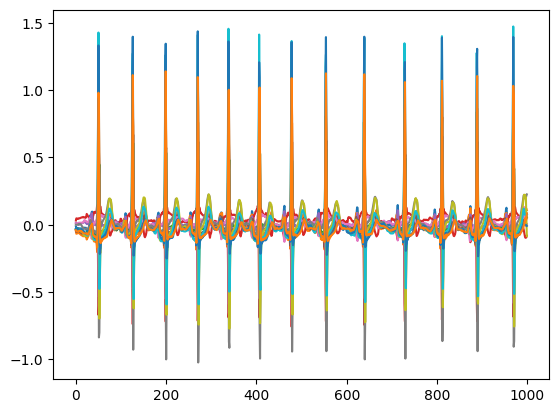

In [48]:
import matplotlib.pyplot as plt

plt.plot(x[1,:,:])
plt.show

### Active learning part

In [59]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    
    data = np.array([signal for signal, meta in data])
    return data


def get_data():

    path='ECG_data/'
    path_csv = 'annotation_active.csv'
    sampling_rate=100

    # load and convert annotation data
    Y = pd.read_csv(path_csv)
    Y = Y_data['diagnostic_superclass'].values
    # Load raw signal data
    X = load_raw_data(Y_data, sampling_rate, path)
    Y = tf.keras.utils.to_categorical(Y, 2)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)
    return X_train, X_test, Y_train, Y_test

In [60]:
X_train, X_test, Y_train, Y_test = get_data()

In [69]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

model = Sequential()
model.add(LSTM(50, activation='relu',return_sequences=True, input_shape=(1000,12)))
model.add(LSTM(50, activation='relu', input_shape=(1000,12)))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))
# Compile the model
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 1000, 50)          12600     
                                                                 
 lstm_10 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_4 (Dropout)         (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 2)                 102       
                                                                 
Total params: 32902 (128.52 KB)
Trainable params: 32902 (128.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [70]:
# Train the model
history = model.fit(X_train, Y_train, epochs=5, batch_size=16, validation_split=0.2, verbose=1)


Epoch 1/5
8/8 [==============================] - 6s 620ms/step - loss: 0.6693 - accuracy: 0.8516 - val_loss: 0.6300 - val_accuracy: 0.9688
Epoch 2/5
8/8 [==============================] - 6s 790ms/step - loss: 0.6063 - accuracy: 1.0000 - val_loss: 0.5698 - val_accuracy: 1.0000
Epoch 3/5
8/8 [==============================] - 5s 587ms/step - loss: 0.5495 - accuracy: 1.0000 - val_loss: 0.5151 - val_accuracy: 1.0000
Epoch 4/5
8/8 [==============================] - 5s 581ms/step - loss: 0.4921 - accuracy: 1.0000 - val_loss: 0.4639 - val_accuracy: 1.0000
Epoch 5/5
8/8 [==============================] - 5s 581ms/step - loss: 0.4418 - accuracy: 1.0000 - val_loss: 0.4172 - val_accuracy: 1.0000


2/2 [==============================] - 0s 155ms/step - loss: 0.4200 - accuracy: 1.0000
Test Loss: [0.4199635088443756, 1.0]
2/2 [==============================] - 0s 143ms/step


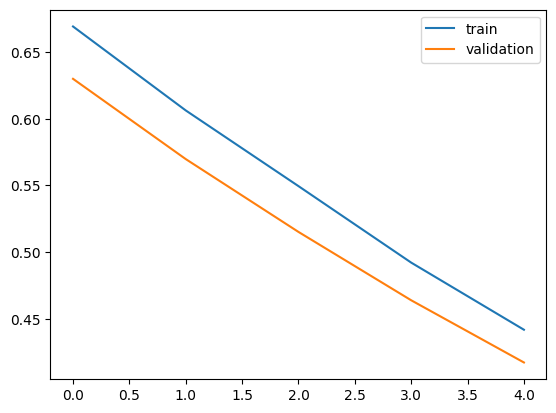

In [71]:
# Evaluate the model
loss = model.evaluate(X_test, Y_test, verbose=1)
print(f'Test Loss: {loss}')

# Make predictions
y_pred = model.predict(X_test)

# Optionally, you can plot the history of training and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()


In [72]:
model.save_weights('weights_active.h5')

In [73]:
np.save('X_test.npy', X_test)
np.save('Y_test.npy', Y_test)